# 01. Líbrerías y Datos

In [2]:
import pandas as pd
import yfinance as yf
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import scipy
from fitter import Fitter
import pmdarima

In [3]:
#Get stock data from google

df= yf.download('AAPL', start='2020-03-31', end='2023-03-31')

[*********************100%%**********************]  1 of 1 completed


In [4]:
px.line(df, y=["Close"], title="AAPL stock price")

In [5]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.update_layout(xaxis_rangeslider_visible=False, title='AAPL Stock Price', xaxis_title='Date', yaxis_title='Price')
#add title

fig.show()

# 02. Movimiento Browniano

In [6]:
df["returns"]= np.log(df.Close) - np.log(df.Close.shift(1))
df

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2020-03-31,63.900002,65.622498,63.000000,63.572498,62.002232,197002000,NaN
2020-04-01,61.625000,62.180000,59.782501,60.227501,58.739853,176218400,-0.054052
2020-04-02,60.084999,61.287498,59.224998,61.232498,59.720036,165934000,0.016549
2020-04-03,60.700001,61.424999,59.742500,60.352501,58.861767,129880000,-0.014476
2020-04-06,62.724998,65.777496,62.345001,65.617500,63.996727,201820400,0.083640
...,...,...,...,...,...,...,...
2023-03-24,158.860001,160.339996,157.850006,160.250000,159.399170,59196500,0.008271
2023-03-27,159.940002,160.770004,157.869995,158.279999,157.439621,52390300,-0.012369
2023-03-28,157.970001,158.490005,155.979996,157.649994,156.812958,45992200,-0.003988


In [7]:
train, test = pmdarima.model_selection.train_test_split(df.Close.dropna(), train_size = 0.8)
training, testing = pmdarima.model_selection.train_test_split(df.returns.dropna(), train_size = 0.8)

In [8]:
f = Fitter(training, timeout = 120)
f.fit()
f.summary()

2024-04-19 06:21:02.592 | WARNING  | fitter.fitter:_fit_single_distribution:347 - SKIPPED _fit distribution (taking more than 120 seconds)
2024-04-19 06:21:03.790 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted anglit distribution with error=8914.111215)
2024-04-19 06:21:04.322 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted argus distribution with error=5283.259316)
2024-04-19 06:21:04.383 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted bradford distribution with error=6141.397291)
2024-04-19 06:21:04.399 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted arcsine distribution with error=8688.976007)
2024-04-19 06:21:04.574 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=807.094227)
2024-04-19 06:21:04.911 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted beta distribution with error=680.418735)
2024-04-19 06:21:05.574 | INFO     | fitter.fitter:_fit_single_di

In [ ]:
f.get_best(method = "bic")

In [ ]:
def GBMsimulatorUniVar(So, mu, sigma, T, N):
    dim = np.size(So)
    S = np.zeros([T + 1, int(N)])
    S[0, :] = So
    for t in range(1, int(T) + 1):
        for i in range(0, int(N)):    
            drift = (mu - 0.5 * sigma**2)
            Z = scipy.stats.laplace.rvs()
            diffusion = sigma*Z
            S[t][i] = S[t - 1][i]*np.exp(drift + diffusion)
    return S[1:]

In [ ]:
prices = GBMsimulatorUniVar(So = df.Close.iloc[len(training)], mu = training.mean(), sigma = training.std(), T = len(test), N = 1000)
newpreds = pd.DataFrame(prices).mean(axis = 1)

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over the columns of the prices array
for i in range(prices.shape[1]):
    # Plot each column as a separate line
    plt.plot(prices[:, i], linewidth=0.5)

# Add title and labels
plt.title('Simulated Stock Prices')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')

# Show the figure
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape(newpreds, test.dropna())

In [ ]:
# Create a new figure
fig = go.Figure()

# Add a line for the train data
fig.add_trace(go.Scatter(x=np.arange(len(train)), y=train, mode='lines', name='Train', line=dict(color='blue')))

# Add a line for the test data
fig.add_trace(go.Scatter(x=np.arange(len(train), len(train) + len(test)), y=test, mode='lines', name='Test', line=dict(color='blue')))

# Add a line for the predictions
fig.add_trace(go.Scatter(x=np.arange(len(train), len(train) + len(test)), y=np.array(newpreds), mode='lines', name='Predictions', line=dict(color='green')))

# Show the figure
fig.show()

# 03. Mejora del Modelo con Poisson Jumps

In [ ]:
import numpy.random as rn

In [ ]:
S0= df.Close.iloc[len(training)]
T= 1
sigma= training.std()
mu= training.mean()
N= len(test)
M= 1000
lambda_= (mu - 0.5 * sigma**2)
theta = scipy.stats.laplace.rvs()*sigma

In [ ]:
ε = rn.randn(M,N)
F_λ = rn.poisson(lambda_,(M,N))
S = S0*np.ones((M,N+1))
dt = T/N

In [ ]:
for i in range(0,N):
    S[:,i+1] = S[:,i]*(1 + theta*F_λ[:,i]*dt + mu*dt + sigma*ε[:,i]*np.sqrt(dt) )

In [ ]:
V = (S[:,-1])

In [ ]:
# Create a new figure
fig = go.Figure()

# Add a line for the train data
fig.add_trace(go.Scatter(x=np.arange(len(train)), y=train, mode='lines', name='Train', line=dict(color='blue')))

# Add a line for the test data
fig.add_trace(go.Scatter(x=np.arange(len(train), len(train) + len(test)), y=test, mode='lines', name='Test', line=dict(color='blue')))

# Add a line for the predictions
fig.add_trace(go.Scatter(x=np.arange(len(train), len(train) + len(test)), y=V, mode='lines', name='Predictions', line=dict(color='green')))

# Show the figure
fig.show()

# 04. Modelo volatilidad GARCH

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import pandas as pd
import yfinance as yf
from arch import arch_model
from datetime import datetime

import pmdarima
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
df= yf.download('AAPL', start='2020-03-31', end='2023-03-31')

[*********************100%%**********************]  1 of 1 completed


Average return: 0.15%


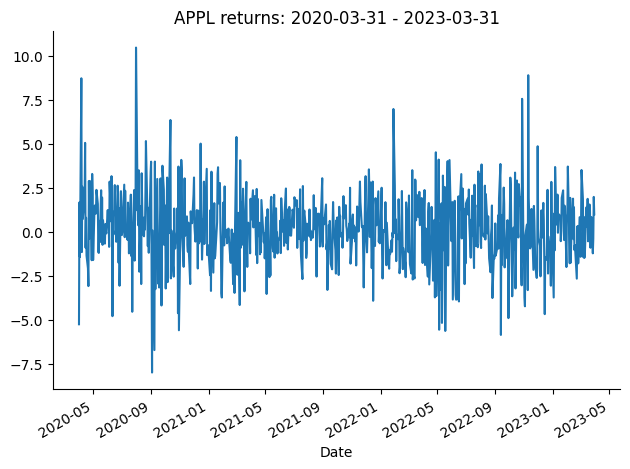

In [3]:
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"
print(f"Average return: {round(returns.mean(), 2)}%")
returns.plot(title=f"APPL returns: 2020-03-31 - 2023-03-31");

sns.despine()
plt.tight_layout()

In [6]:
# fit ARIMA on returns
arima_model_fitted = pmdarima.auto_arima(returns)

p, d, q = arima_model_fitted.order
arima_residuals = arima_model_fitted.arima_res_.resid
print('p=',p,'d=',d,'q=',q)

p= 0 d= 0 q= 0


In [7]:
model = SARIMAX(returns,order=(p, d, q))
res = model.fit()
res.summary()

c:\Users\Hp\Documents\GitHub\Proyectos-de-Ingenieria-Matematica\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Hp\Documents\GitHub\Proyectos-de-Ingenieria-Matematica\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          asset_returns   No. Observations:                  755
Model:                        SARIMAX   Log Likelihood               -1613.992
Date:                Thu, 02 May 2024   AIC                           3229.983
Time:                        10:05:31   BIC                           3234.610
Sample:                             0   HQIC                          3231.765
                                - 755                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         4.2106      0.153     27.546      0.000       3.911       4.510
===================================================================================
Ljung-Box (L1) (Q):                   1.84   Jarque-Bera (JB):               128.51
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.17
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

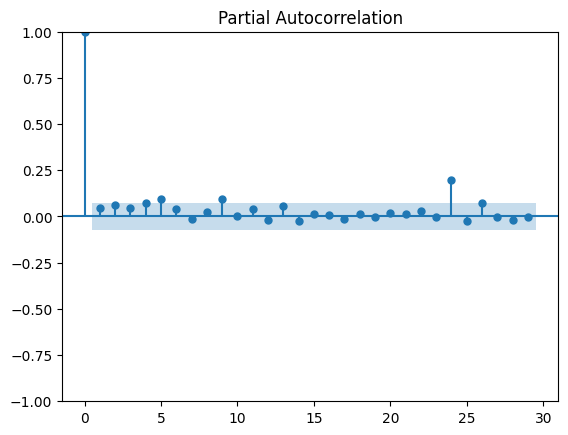

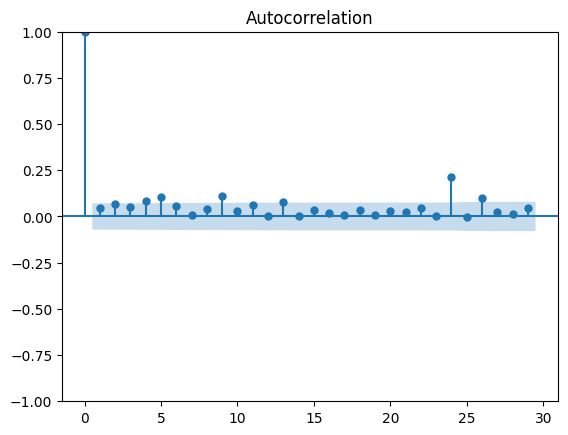

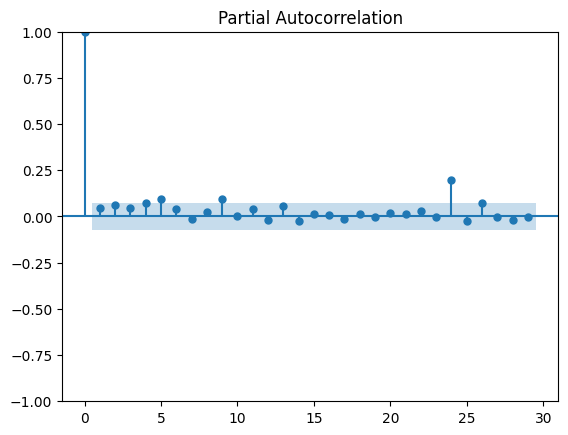

In [8]:
plot_acf(arima_residuals**2)
plot_pacf(arima_residuals**2)

In [9]:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1586.87
Distribution:                  Normal   AIC:                           3179.73
Method:            Maximum Likelihood   BIC:                           3193.61
                                        No. Observations:                  755
Date:                Thu, May 02 2024   Df Residuals:                      755
Time:                        10:05:34   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0822  6.545e-02      1.256      0.209  [-

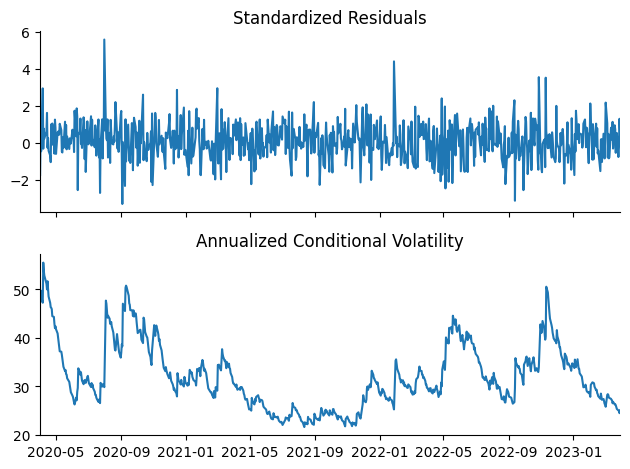

In [10]:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()

In [11]:
results = pd.DataFrame(columns=["p", "q", "AIC", "BIC"])

In [12]:
# Loop over different values of p and q
for p in range(0, 3):
    for q in range(0, 3):
        try:
            model = arch_model(returns, mean="Zero", vol="GARCH", p=p, q=q)
            fitted_model = model.fit(disp="off")
            print(f"p={p}, q={q}: AIC={fitted_model.aic}, BIC={fitted_model.bic}")
            
            new_row = {"p": p, "q": q, "AIC": fitted_model.aic, "BIC":fitted_model.bic}
            results.loc[len(results)]  = new_row
        
        except:
            pass

p=1, q=0: AIC=3225.5917716459526, BIC=3234.845207144451
p=1, q=1: AIC=3179.7339060990216, BIC=3193.6140593467685
p=1, q=2: AIC=3181.73390607625, BIC=3200.240777073246
p=2, q=0: AIC=3221.5494718179316, BIC=3235.4296250656785
p=2, q=1: AIC=3181.691957878945, BIC=3200.1988288759408
p=2, q=2: AIC=3183.2509648042815, BIC=3206.3845535505266


In [13]:
results

,p,q,AIC,BIC
0,1,0,3225.591772,3234.845207
1,1,1,3179.733906,3193.614059
2,1,2,3181.733906,3200.240777
3,2,0,3221.549472,3235.429625
4,2,1,3181.691958,3200.198829
5,2,2,3183.250965,3206.384554


In [14]:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1586.87
Distribution:                  Normal   AIC:                           3179.73
Method:            Maximum Likelihood   BIC:                           3193.61
                                        No. Observations:                  755
Date:                Thu, May 02 2024   Df Residuals:                      755
Time:                        10:06:13   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0822  6.545e-02      1.256      0.209  [-